## Let's look at boundary and label monotonicity in Hierarchical labels: SALAMI.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Let's get the directory of jams files:
import os, jams, mir_eval, bnl, json
import numpy as np
import xarray as xr

In [7]:
# DATA_DIR = '/Users/xi/data/salami-jams'
DATA_DIR = '/Users/tomxi/data/salami-jams'

In [8]:
def load_jams(tid, salami_jams_dir=DATA_DIR):
    jams_path = os.path.join(salami_jams_dir, tid + '.jams')
    return jams.load(jams_path)

def get_salami_tids(salami_jams_dir=DATA_DIR):
    found_jams_files = os.listdir(salami_jams_dir)
    tids = sorted([os.path.splitext(f)[0] for f in found_jams_files])
    return tids

In [9]:
# Let's do it on 1 file, and see if upper and lower bounds are monotonic

def get_hiers(tid):
    jam = load_jams(str(tid))
    duration = jam.file_metadata.duration
    upper = jam.search(namespace='segment_salami_upper')
    lower = jam.search(namespace='segment_salami_lower')
    anno_h_list = []
    for anno_id in range(len(upper)):
        upper[anno_id].duration = duration
        lower[anno_id].duration = duration
        anno_h = bnl.multi2H(bnl.fmt.openseg2multi([upper[anno_id], lower[anno_id]]))
        anno_h_list.append(anno_h)
    return anno_h_list

for h in get_hiers(10):
    print(h.has_mono_B())

False
True


In [10]:
def get_adobe_hiers(tid, result_dir='/Users/tomxi/data/ISMIR21-Segmentations/SALAMI/def_mu_0.1_gamma_0.1/') -> jams.Annotation:
    filename = f'{tid}.mp3.msdclasscsnmagic.json'

    with open(os.path.join(result_dir, filename), 'rb') as f:
        adobe_hier = json.load(f)

    anno = bnl.fmt.hier2multi(adobe_hier)
    anno.sandbox.update(mu=0.1, gamma=0.1)
    return anno

In [28]:
adobe_hier = bnl.multi2H(get_adobe_hiers(10))

False


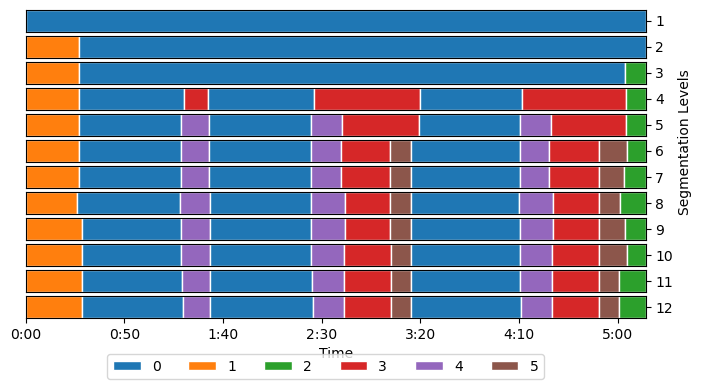

In [29]:
adobe_hier.plot()
print(adobe_hier.has_mono_B())

(<Figure size 800x400 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

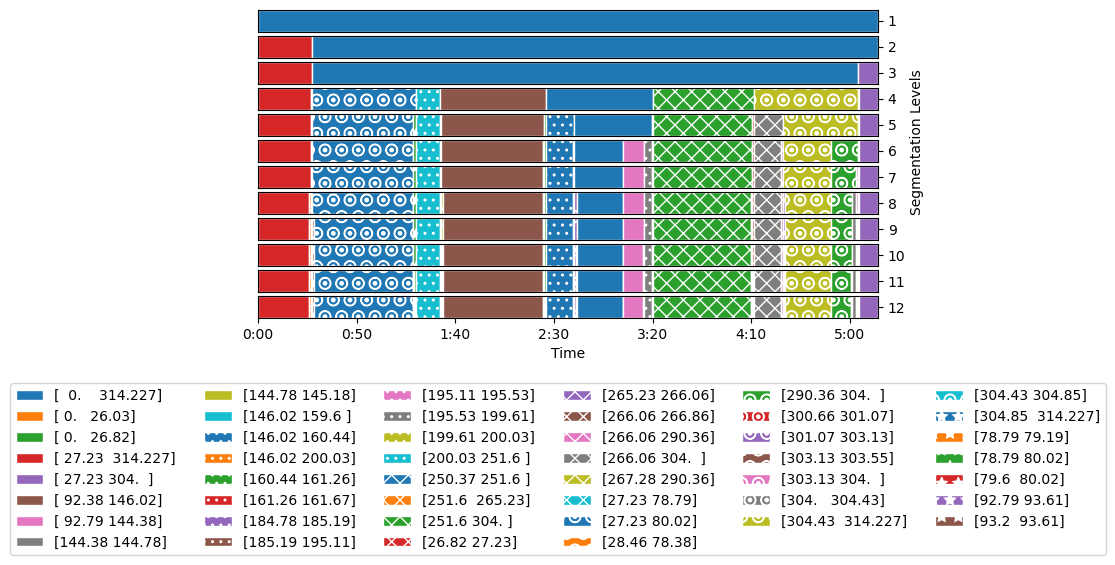

In [35]:
out = bnl.H(adobe_hier.force_mono_B(min_seg_dur=0).itvls)
out.plot(legend_offset=-0.5)

(<Figure size 800x400 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

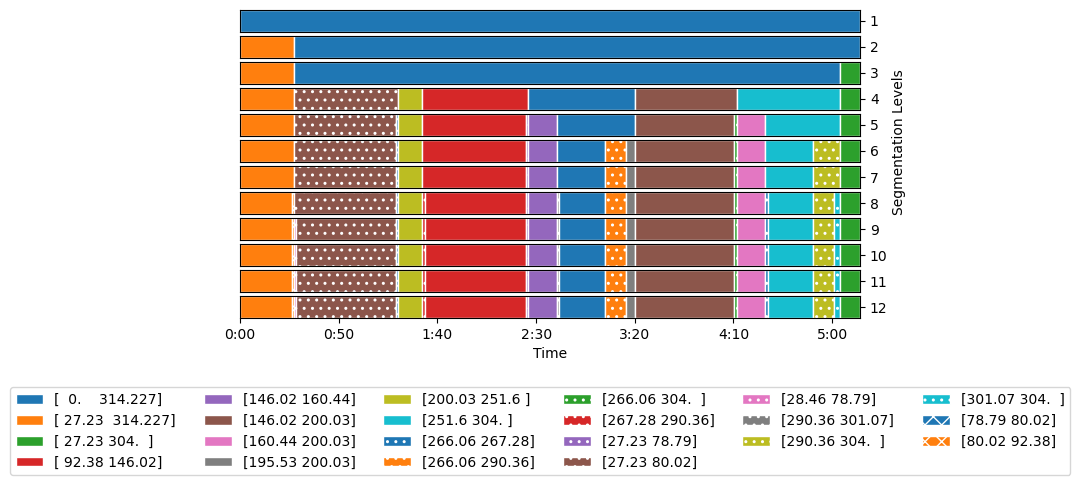

In [36]:
out = bnl.H(adobe_hier.force_mono_B(min_seg_dur=1).itvls)
out.plot(legend_offset=-0.3)

(<Figure size 800x400 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

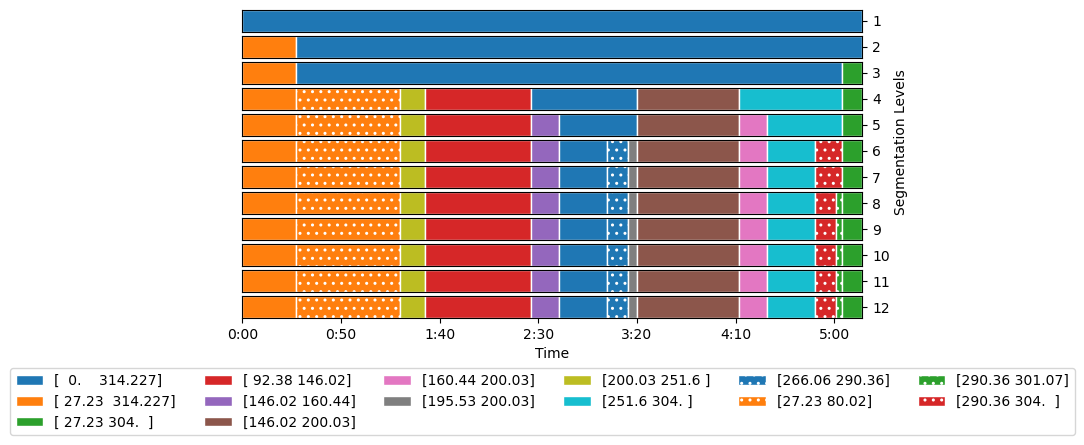

In [37]:
out = bnl.H(adobe_hier.force_mono_B(min_seg_dur=2).itvls)
out.plot(legend_offset=-0.2)

In [ ]:
# Let's do it on all files
from tqdm import tqdm

for tid in tqdm(get_salami_tids()):
    hiers = get_hiers(tid)
    for anno_id, h in enumerate(hiers):
        if not h.has_mono_B():
            print(f'{tid} annotator {anno_id} has non-monotonic boundaries!')

## Everything has monotonic boundaries!

100%|██████████| 1359/1359 [00:13<00:00, 101.53it/s]


(<Figure size 800x500 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time'>], dtype=object))

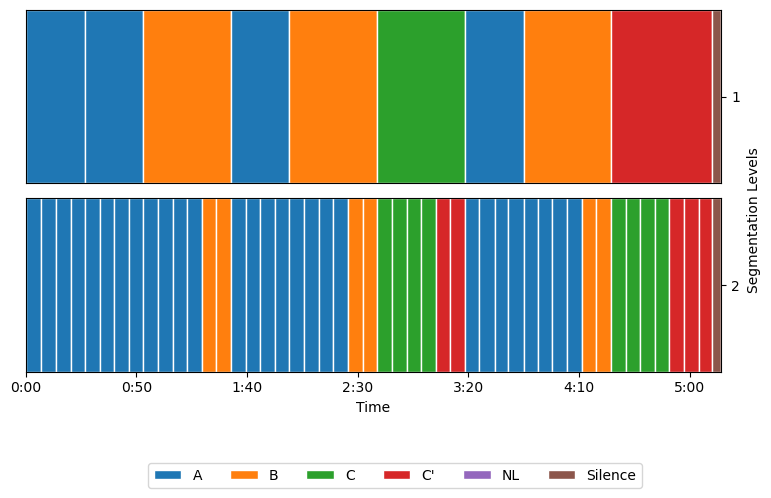

In [19]:
hiers[1].plot()